In [1]:
# @title 連接google drive
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi
import os
os.chdir('/content/drive/My Drive')
os.getcwd()
os.chdir('/content/drive/My Drive/112 Sesmester/data2')
os.getcwd()

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found


'/content/drive/My Drive/112 Sesmester/data2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm

In [3]:

df = pd.read_csv("merged_df5.csv")
print(df)
print(df.info())
# df.describe(include="all")
print("object行:\n",df.select_dtypes(include="object").columns)
print("缺失值:\n",df.isnull().sum())
print("唯一值:\n",df[:].nunique())

       Unnamed: 0       ID Delivery_person_ID  Delivery_person_Age  \
0               2  0x1002    COIMBRES07DEL01                  30.0   
1               3  0x1005     VADRES010DEL03                  23.0   
2               5  0x1006    COIMBRES01DEL01                  32.0   
3               7  0x100f     CHENRES09DEL02                  35.0   
4              10  0x1010     INDORES20DEL02                  37.0   
...           ...      ...                ...                  ...   
17740       29073   0xff1      MYSRES19DEL02                  22.0   
17741       29074   0xff4      MYSRES04DEL01                  22.0   
17742       29075   0xff7      SURRES18DEL01                  30.0   
17743       29076   0xff9      VADRES11DEL01                  30.0   
17744       29077   0xffa      MYSRES09DEL03                  34.0   

       Delivery_person_Ratings  Restaurant_latitude  Restaurant_longitude  \
0                          4.6            10.961850             76.971082   
1    

In [4]:
# # columns_to_drop = ['Unnamed: 0','ID', 'Delivery_person_ID', 'Order_Date', 'Time_Orderd', 'Time_Order_picked',
# #                    'Route', 'Time_taken(min)','City','multiple_deliveries','Type_of_vehicle','Delivery_person_Age','Delivery_person_Ratings']
# columns_to_drop = ['Unnamed: 0','ID', 'Delivery_person_ID', 'Order_Date', 'Time_Orderd', 'Time_Order_picked',
#                    'Route', 'Time_taken(min)','Type_of_vehicle']
# data = data.drop(columns_to_drop, axis=1)
# data.columns

In [4]:
# @title 填補缺失值
# Analyzing the dataset to suggest suitable methods for imputing missing values in each column
data=df
# Checking for missing values in each column
# Analyzing the dataset to suggest suitable methods for imputing missing values in each column

# Checking for missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Checking the data types of columns with missing values
data_types = data[missing_values.index].dtypes

# Preparing a summary of columns with missing values, their data types, and suggested imputation methods
imputation_methods = []

for column, missing_count in missing_values.iteritems():
    dtype = data_types[column]
    if dtype == 'object':
        # Suggesting mode imputation for categorical data
        method = 'Mode (for categorical data)'
    elif dtype in ['int64', 'float64']:
        # Suggesting mean or median imputation for numerical data, depending on the distribution
        if data[column].skew() < 1 and data[column].skew() > -1:
            method = 'Mean (for approximately normal distribution)'
        else:
            method = 'Median (for skewed distribution)'
    else:
        method = 'Special consideration required'

    imputation_methods.append((column, dtype, missing_count, method))

imputation_summary = pd.DataFrame(imputation_methods, columns=['Column', 'Data Type', 'Missing Values', 'Suggested Method'])

imputation_summary.sort_values(by='Missing Values', ascending=False)


<ipython-input-4-1896cabd09c3>:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, missing_count in missing_values.iteritems():


,Column,Data Type,Missing Values,Suggested Method
4,City,object,434,Mode (for categorical data)
2,multiple_deliveries,float64,364,Mean (for approximately normal distribution)
1,Delivery_person_Ratings,float64,111,Median (for skewed distribution)
0,Delivery_person_Age,float64,90,Mean (for approximately normal distribution)
3,Festival,object,78,Mode (for categorical data)


In [5]:
# @title 填補缺失值
# Filling missing values for each column based on the suggested methods

# Defining functions for different imputation methods
def impute_mode(column):
    return column.fillna(column.mode()[0])

def impute_mean(column):
    return column.fillna(column.mean())

def impute_median(column):
    return column.fillna(column.median())

# Applying the imputation methods to each column
for column, dtype, _, method in imputation_methods:
    if method == 'Mode (for categorical data)':
        data[column] = impute_mode(data[column])
    elif method == 'Mean (for approximately normal distribution)':
        data[column] = impute_mean(data[column])
    elif method == 'Median (for skewed distribution)':
        data[column] = impute_median(data[column])

# Checking if there are any missing values left
remaining_missing_values = data.isnull().sum().sum()

remaining_missing_values, data.head()


(0,
    Unnamed: 0       ID Delivery_person_ID  Delivery_person_Age  \
 0           2  0x1002    COIMBRES07DEL01                  30.0   
 1           3  0x1005     VADRES010DEL03                  23.0   
 2           5  0x1006    COIMBRES01DEL01                  32.0   
 3           7  0x100f     CHENRES09DEL02                  35.0   
 4          10  0x1010     INDORES20DEL02                  37.0   
 
    Delivery_person_Ratings  Restaurant_latitude  Restaurant_longitude  \
 0                      4.6            10.961850             76.971082   
 1                      4.4            22.310329             73.169083   
 2                      4.9            11.016298             76.972076   
 3                      4.9            13.044694             80.261470   
 4                      4.6            22.732225             75.874765   
 
    Delivery_location_latitude  Delivery_location_longitude Order_Date  ...  \
 0                   11.001850                    77.011082  2022/3

In [7]:
# columns_to_drop = ['Unnamed: 0','ID', 'Delivery_person_ID', 'Order_Date', 'Time_Orderd', 'Time_Order_picked',
#                    'Route', 'Time_taken(min)','City','multiple_deliveries','Type_of_vehicle','Delivery_person_Age','Delivery_person_Ratings']
# columns_to_drop = ['Unnamed: 0','ID', 'Delivery_person_ID', 'Order_Date', 'Time_Orderd', 'Time_Order_picked',
#                    'Route', 'Time_taken(min)','Type_of_vehicle']
columns_to_drop =['Idx',
       'Restaurant_Lat', 'Restaurant_Lon', 'Delivery_Lat', 'Delivery_Lon', 'Group','Vehicle_condition']
data = data.drop(columns_to_drop, axis=1)
data.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Weatherconditions',
       'Road_traffic_density', 'Type_of_order', 'multiple_deliveries',
       'Festival', 'City', 'Distance_km', 'Time_Orderd_in_minutes',
       'location_cluster', 'date_category', 'Total_Distance_km',
       'Max_Time_Diff_Minutes', 'Shortest_Path_Distance_km',
       'Carbon_Reduction_g', 'Group_Length', 'Waiting_Time_Minutes',
       'Combined_Count'],
      dtype='object')

In [20]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# from lightgbm import LGBMRegressor
# !pip install catboost
# from catboost import CatBoostRegressor


def train_and_evaluate(X_train, y_train, X_test, y_test):
    models = [
        ('XGBoost', xgb.XGBRegressor(), None, True),
        ('LightGBM', lgb.LGBMRegressor(), None, True),
        ('Random Forest', RandomForestRegressor(), None, False),

    ]
    best_model = None
    best_model_name = ""
    best_score = float('inf')

    for name, model, dtest, adjust_threshold in tqdm(models, desc="Training and evaluating models"):
        print(f"\n模型: {name}")

        # XGBoost
        if name == 'XGBoost':
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)
            params = {'max_depth': 3, 'eta': 0.3, 'objective': 'reg:squarederror'}  # 适用于回归的参数
            num_round = 100
            bst = xgb.train(params, dtrain, num_round)
            y_test_pred = bst.predict(dtest)

        # LightGBM
        elif name == 'LightGBM':
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)

        # 其他 Scikit-learn 风格的模型
        else:
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)

        # 评估性能
        mse = mean_squared_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)
        print(f"MSE: {mse}, R²: {r2}")
        # 检查是否是目前最好的模型
        if best_score > mse:
            best_score = mse
            best_model = model
            best_model_method_name=method_name
            best_model_name = name

            # print(f"best mse occur: {best_score}")

    return best_model_name,best_model,best_score

def evaluate_model_with_threshold(y_test, y_pred):
    # 确定最佳阈值
    best_threshold = 0.5
    best_f1 = 0
    for threshold in np.linspace(0, 1, 100):
        y_pred_binary = np.where(y_pred > threshold, 1, 0)
        f1 = f1_score(y_test, y_pred_binary)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    y_pred_binary = np.where(y_pred > best_threshold, 1, 0)
    return calculate_metrics(y_test, y_pred_binary)

# def evaluate_model_without_threshold(y_test, y_pred):
#     return calculate_metrics(y_test, y_pred)

# def calculate_metrics(y_test, y_pred_binary):
#     f1 = f1_score(y_test, y_pred_binary)
#     conf_matrix = confusion_matrix(y_test, y_pred_binary)
#     sensitivity = recall_score(y_test, y_pred_binary)
#     tn, fp, fn, tp = conf_matrix.ravel()
#     specificity = tn / (tn + fp)
#     g_mean = np.sqrt(sensitivity * specificity)
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)
#     roc_auc = auc(fpr, tpr)

#     return f1, conf_matrix, sensitivity, g_mean, roc_auc



# 数据预处理
X = data.drop('Waiting_Time_Minutes', axis=1)
y = data['Waiting_Time_Minutes']  # 使用 Waiting_Time_Minutes 作为目标

X_encoded = pd.get_dummies(X)
y_encoded = LabelEncoder().fit_transform(y)


# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)
# len(X_train), len(X_test), len(y_train), len(y_test)

# 定义不同的数据扩充方法
methods = [
    ('原始数据', X_train, y_train),
    ('随机过采样', *RandomOverSampler(random_state=42).fit_resample(X_train, y_train)),
    ('随机欠采样', *RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)),
    ('SMOTE', *SMOTE(random_state=42).fit_resample(X_train, y_train)),
    ('ADASYN', *ADASYN(random_state=42).fit_resample(X_train, y_train))

]

# 存储结果的字典
results = {}
# 初始化最佳模型和性能指标
best_modelF = None
best_model_nameF = ""
best_scoreF = float('inf')  # 对于 MSE，较低的值表示更好的模型

best_model_method_name=""
# 进行模型训练和评估的循环
for method_name, X_augmented, y_augmented in tqdm(methods, desc="Training Models"):
    print(method_name)
    best_model_name,best_model, best_score = train_and_evaluate(X_augmented, y_augmented, X_test, y_test)
    if best_scoreF > best_score:
            best_scoreF = best_score
            best_modelF = best_model
            best_model_method_name= method_name
            best_model_nameF = best_model_name
            print(f"RR best mse occur: {best_score}")


import joblib

if best_model_nameF in ['XGBoost', 'LightGBM']:
    # 使用模型特有的保存方法
    if best_model_nameF == 'XGBoost':
        best_modelF.save_model(f'{best_model_method_name}_{best_model_nameF}_best_model.json')
    elif best_model_nameF == 'LightGBM':
        best_modelF.booster_.save_model(f'{best_model_method_name}_{best_model_nameF}_best_model.txt')
else:
    # 对于其他模型，使用 joblib
    joblib.dump(best_modelF, f'{best_model_method_name}_{best_model_nameF}_best_model.pkl')

print(f"最佳模型: {best_model_method_name} {best_model_nameF}，MSE: {best_scoreF}")

Training Models:   0%|          | 0/5 [00:00<?, ?it/s]

原始数据



Training and evaluating models:   0%|          | 0/3 [00:00<?, ?it/s]


模型: XGBoost



Training and evaluating models:  33%|███▎      | 1/3 [00:00<00:00,  4.60it/s]

MSE: 1.982182348651181, R²: 0.1384632696625525
best mse occur: 1.982182348651181

模型: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2388
[LightGBM] [Info] Number of data points in the train set: 12421, number of used features: 36
[LightGBM] [Info] Start training from score 1.546574



Training and evaluating models:  67%|██████▋   | 2/3 [00:00<00:00,  3.72it/s]

MSE: 1.9660249809113666, R²: 0.14548591608198602
best mse occur: 1.9660249809113666

模型: Random Forest



Training Models:  20%|██        | 1/5 [00:21<01:24, 21.12s/it]

MSE: 2.079198009015778, R²: 0.09629633437583762
RR best mse occur: 1.9660249809113666
随机过采样



Training and evaluating models:   0%|          | 0/3 [00:00<?, ?it/s]


模型: XGBoost



Training and evaluating models:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

MSE: 2.13989897707578, R²: 0.06991323516888615
best mse occur: 2.13989897707578

模型: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2386
[LightGBM] [Info] Number of data points in the train set: 24400, number of used features: 36
[LightGBM] [Info] Start training from score 2.000000



Training and evaluating models:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

MSE: 2.0967207136257753, R²: 0.08868025725425543
best mse occur: 2.0967207136257753

模型: Random Forest



Training Models:  40%|████      | 2/5 [00:59<01:34, 31.56s/it]

MSE: 2.083298628850488, R²: 0.0945140389138901
best mse occur: 2.083298628850488
随机欠采样



Training and evaluating models:   0%|          | 0/3 [00:00<?, ?it/s]


模型: XGBoost


MSE: 2.178994118044641, R²: 0.05292090348693279
best mse occur: 2.178994118044641


Training and evaluating models:  33%|███▎      | 1/3 [00:00<00:00,  4.94it/s]


模型: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 8860, number of used features: 36
[LightGBM] [Info] Start training from score 2.000000



Training and evaluating models:  67%|██████▋   | 2/3 [00:00<00:00,  4.10it/s]

MSE: 2.183951192189859, R²: 0.05076635829384413

模型: Random Forest



Training Models:  60%|██████    | 3/5 [01:14<00:47, 23.57s/it]

MSE: 2.238531987227648, R²: 0.027043334159322252
SMOTE



Training and evaluating models:   0%|          | 0/3 [00:00<?, ?it/s]


模型: XGBoost



Training and evaluating models:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

MSE: 1.9976692591667473, R²: 0.13173203110738685
best mse occur: 1.9976692591667473

模型: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4124
[LightGBM] [Info] Number of data points in the train set: 24400, number of used features: 36
[LightGBM] [Info] Start training from score 2.000000



Training and evaluating models:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

MSE: 1.98366214768951, R²: 0.13782008906622345
best mse occur: 1.98366214768951

模型: Random Forest



Training Models:  80%|████████  | 4/5 [02:02<00:33, 33.53s/it]

MSE: 2.0883246055597295, R²: 0.09232954587581088
ADASYN



Training and evaluating models:   0%|          | 0/3 [00:00<?, ?it/s]


模型: XGBoost



Training and evaluating models:  33%|███▎      | 1/3 [00:01<00:03,  1.98s/it]

MSE: 1.989148777348349, R²: 0.13543537759905433
best mse occur: 1.989148777348349

模型: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4124
[LightGBM] [Info] Number of data points in the train set: 25351, number of used features: 36
[LightGBM] [Info] Start training from score 2.004300



Training and evaluating models:  67%|██████▋   | 2/3 [00:02<00:01,  1.40s/it]

MSE: 1.978798415663836, R²: 0.13993406399365027
best mse occur: 1.978798415663836

模型: Random Forest



Training Models: 100%|██████████| 5/5 [02:52<00:00, 34.48s/it]

MSE: 2.103656461307288, R²: 0.0856657004027922
最佳模型: 原始数据 LightGBM，MSE: 1.9660249809113666


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

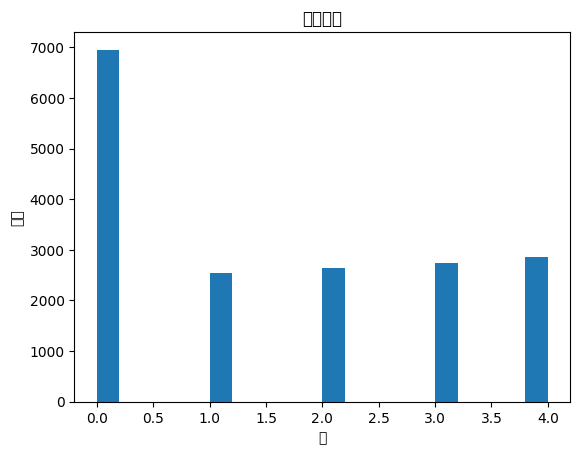

In [22]:

import matplotlib.pyplot as plt

plt.hist(y_encoded, bins=20)  # bins 参数决定直方图的条形数
plt.title("数据分布")
plt.xlabel("值")
plt.ylabel("频率")
plt.show()

In [ ]:
from datetime import datetime, timedelta

# Convert 'Order_Date' to datetime format
data['Order_Date'] = pd.to_datetime(data['Order_Date'])

# Sorting the data by 'Order_Date' and 'Time_Orderd_in_minutes'
sorted_data = data.sort_values(by=['Order_Date', 'Time_Orderd_in_minutes'])

# Calculate the time until next 'IsGreenOrder' == 1 in minutes
time_to_next_green_order = []
for index, row in sorted_data.iterrows():
    # Finding future orders where 'IsGreenOrder' == 1
    future_green_orders = sorted_data[(sorted_data['Order_Date'] > row['Order_Date']) |
                                      ((sorted_data['Order_Date'] == row['Order_Date']) &
                                       (sorted_data['Time_Orderd_in_minutes'] > row['Time_Orderd_in_minutes'])) &
                                      (sorted_data['IsGreenOrder'] == 1)]

    if not future_green_orders.empty:
        next_green_order = future_green_orders.iloc[0]
        # Calculate the time difference in minutes
        date_diff = (next_green_order['Order_Date'] - row['Order_Date']).days * 24 * 60  # Days to minutes
        time_diff = date_diff + (next_green_order['Time_Orderd_in_minutes'] - row['Time_Orderd_in_minutes'])
    else:
        time_diff = None  # No next green order found
    time_to_next_green_order.append(time_diff)
    print(f'append{time_diff}')
# Adding the calculated time to the sorted data
sorted_data['Time_to_Next_Green_Order'] = time_to_next_green_order

# Display the updated sorted dataframe
sorted_data[['Order_Date', 'Time_Orderd_in_minutes', 'IsGreenOrder', 'Time_to_Next_Green_Order']].head()


In [ ]:
# @title 填補缺失值
# Analyzing the dataset to suggest suitable methods for imputing missing values in each column
data= pd.read_csv('/content/drive/My Drive/112 Sesmester/data2/featureS.csv')
columns_to_drop = ['Unnamed: 0', 'Time_Orderd_in_minutes','Time_taken(min)',
                   'Route', 'Time_taken(min)','City','multiple_deliveries','Type_of_vehicle']
data = data.drop(columns_to_drop, axis=1)
data.columns

data=df
# Checking for missing values in each column
# Analyzing the dataset to suggest suitable methods for imputing missing values in each column

# Checking for missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Checking the data types of columns with missing values
data_types = data[missing_values.index].dtypes

# Preparing a summary of columns with missing values, their data types, and suggested imputation methods
imputation_methods = []

for column, missing_count in missing_values.iteritems():
    dtype = data_types[column]
    if dtype == 'object':
        # Suggesting mode imputation for categorical data
        method = 'Mode (for categorical data)'
    elif dtype in ['int64', 'float64']:
        # Suggesting mean or median imputation for numerical data, depending on the distribution
        if data[column].skew() < 1 and data[column].skew() > -1:
            method = 'Mean (for approximately normal distribution)'
        else:
            method = 'Median (for skewed distribution)'
    else:
        method = 'Special consideration required'

    imputation_methods.append((column, dtype, missing_count, method))

imputation_summary = pd.DataFrame(imputation_methods, columns=['Column', 'Data Type', 'Missing Values', 'Suggested Method'])

imputation_summary.sort_values(by='Missing Values', ascending=False)
# @title 填補缺失值
# Filling missing values for each column based on the suggested methods

# Defining functions for different imputation methods
def impute_mode(column):
    return column.fillna(column.mode()[0])

def impute_mean(column):
    return column.fillna(column.mean())

def impute_median(column):
    return column.fillna(column.median())

# Applying the imputation methods to each column
for column, dtype, _, method in imputation_methods:
    if method == 'Mode (for categorical data)':
        data[column] = impute_mode(data[column])
    elif method == 'Mean (for approximately normal distribution)':
        data[column] = impute_mean(data[column])
    elif method == 'Median (for skewed distribution)':
        data[column] = impute_median(data[column])

# Checking if there are any missing values left
remaining_missing_values = data.isnull().sum().sum()

remaining_missing_values, data.head()


In [ ]:
sorted_data['Time_to_Next_Green_Order'].value_counts()
sorted_data.to_csv('/content/drive/My Drive/112 Sesmester/data2/sorted_data')

In [ ]:
sorted_data[['Order_Date', 'Time_Orderd_in_minutes', 'IsGreenOrder', 'Time_to_Next_Green_Order']]


In [ ]:
# Sorting the data by 'Order_Date' and 'Time_Ordered'
sorted_data = data.sort_values(by=['Order_Date', 'Time_Ordered'])

# Display the first few rows of the sorted dataframe
sorted_data.head()
sorted_data[['Order_Date', 'Time_Ordered', 'IsGreenOrder', 'Time_to_Next_Green_Order']]

In [ ]:
data[ 'Time_to_Next_Green_Order'].value_counts()